<h1>
<center>Empirical Asset Pricing via Machine Learning</center>
</h1>



<center>Alexander Margetis, Lanya Ma, Sheng Yang, Yiming Tan</center>



## 1. Introduction



In this project, we conducted an empirical analysis of machine learning methods in asset pricing. We aim to measure and predict risk premium with bundles of underlying factors. In particular, we attempt to study the structure of cross-sectional returns by using various factors. These factors can be stock-level firm characteristics, macroeconomic descriptors and many other derived indicators. In the empirical literature, classical models are proposed to estimate and explain the risk premia with several factors, like CAPM, Fama-French 3 factor and later Fama-French 5 factor model. These models are basically linear projection from bahavior of stocks' expected returns to multiple variates. As the high-dimensional nature is innate in machine learning methods, we can enhances the flexibility of representing assets risk profile relative to more traditional econometric prediction techniques.And the functionals which project high-dimensional predictors to risk premia can be complicated. That's why the application of machine learning in this field can be rather attractive.   

Our major contributions in this project are three-fold. First, we investigate machine learning techniques in prediction of cross-sectional returns. This tells us whether machine learning algorithms can improve the estimation of out-of-sample expected returns. Second, we examine the feature importance of factors.This process gives us insights that how to select informative factors. Third, we study the stability of machine learning in portfolio constrcution. We analyze the performance of long-short portfolio from the algorithms over the horizon.

## 2. Methodology

### 2.1 Data Preprocessing and Exploratory Data Analysis (Lanya Ma and Yiming Tan)

Data Cleaning (Lanya Ma)

In [1]:
import pandas as pd
import os
import glob
import numpy as np
os.chdir('C:/Users/Jack Tan/Desktop/CFRM521Project-master/data')
extension = 'csv'
result = glob.glob('*.{}'.format(extension))
print(result)
data_name_list = list(map(lambda x: x[:-4] , result)) 

['3m_tbill_rate.csv', 'bps.csv', 'ca_to_assets.csv', 'current.csv', 'debt_over_asset.csv', 'ebitda_to_sales.csv', 'eps_ttm.csv', 'equity_to_totalcap.csv', 'GICS_code.csv', 'market_cap.csv', 'netprofit_margin.csv', 'ocf_ps.csv', 'ocf_to_debt.csv', 'ocf_to_sales.csv', 'op_to_debt.csv', 'pb.csv', 'pe_ttm.csv', 'price.csv', 'ps_ttm.csv', 'roa.csv', 'roe.csv', 'roic.csv', 'sales_growth1yr.csv', 'tax_to_ebt.csv', 'turnover.csv']


In [2]:
import copy
import numpy as np

def transform_row(filename):
    raw_df = pd.read_csv(filename)
    row_names = raw_df.iloc[:,0]
    raw_df = raw_df.rename(index = row_names)
    new_df = raw_df.drop(raw_df.columns[0],axis = 1)
    return new_df

#Omit stocks w/ no price
price = transform_row('price.csv')
sum_df = pd.DataFrame(price.sum(axis = 1)).reset_index()
valid = sum_df[sum_df[0]!=0].index.values

price_v = price.iloc[valid,:]
is_available = copy.deepcopy(price_v)
is_available[:] = np.nan
is_available[price_v != 0] = 1
price_df = price_v*is_available


def tranfrom_missing(filename):
    raw =  transform_row(filename)
    raw = raw.iloc[valid,:]
    nrow = raw.shape[0]
    ncol = raw.shape[1]
    raw = raw.applymap(lambda x: float(x))
    raw_mat = np.asmatrix(raw)
    for i in range(0,nrow):
        fill_data = 0
        for j in range(0,ncol):
            if raw_mat[i,j] != 0:
                fill_data = raw_mat[i,j]
            else:
                raw_mat[i,j] = fill_data
    filled_df = pd.DataFrame(raw_mat)
    filled_df.index = price_v.index.values
    filled_df.columns = price_v.columns.values
    filled_df = np.multiply(filled_df,is_available)
    filled_df[filled_df == 0] = np.nan
    return filled_df


sector_code = transform_row('GICS_code.csv')
sector_code[sector_code ==0] = np.nan
"""
sector_intcode = []
for code in sector_code['GICS_Code']:
    if ~np.isnan(code):
        code = int(code)
    sector_intcode.append(code)
"""

# Consider S&P Dow Jones Indices and MSCI changed sector classification
sector_dict = {1010:"Energy", 1510:"Materials",2010:"Capital Goods", 2020:"Commercial & Professional Services",
               2030:"Transportation", 2510:"Automobiles & Components", 2520:"Consumer Durables & Apparel",
               2530:"Consumer Services", 2540:"Media & Entertainment", 2550:"Retailing", 3010:"Food & Staples Retailing",
               3020:"Food, Beverage & Tobacco", 3030:"Household & Personal Products", 3510:"Health Care Equipment & Services",
               3520:"Pharmaceuticals, Biotechnology & Life Sciences", 4010:"Banks", 4020:"Diversified Financials",
               4030:"Insurance", 4040:"Real Estate",4510:"Software & Services", 4520:"Technology Hardware & Equipment",
               4530:"Semiconductors & Semiconductor Equipment", 5010:"Telecommunication Services", 5020:"Media & Entertainment",
               5510:"Utilities", 6010:"Real Estate"}    

sectors_list = []
for code in sector_code['GICS_Code']:
    if ~np.isnan(code):
        code = sector_dict[code]
    sectors_list.append(code)

In [3]:
features_dict = {}
numeric_features = []
for idx, element in enumerate(result):
    feature_name = data_name_list[idx]
    if feature_name not in ['3m_tbill_rate','GICS_code','price']:
        feature_df = tranfrom_missing(element)
        features_dict[data_name_list[idx]] = feature_df
        numeric_features.append(feature_name)

In [4]:
#Stock return
return_mon = (price_df - price_df.T.shift(1).T)/price_df.T.shift(1).T
# shift the next month return ahead so that we can concatenate features and target
return_mon = return_mon.T.shift(-1).T
#Risk free rate
rf= transform_row('3m_tbill_rate.csv')
rfree = rf['rate'][return_mon.columns.values]/12

In [5]:
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
#Raw Data Dictionary
data_dict = {}
time_keys = price.columns.values
first_feature = list(features_dict.keys())[0]
sectors_array = np.array(sectors_list).reshape(-1, 1)
sectors_array = sectors_array[valid]
for time_key in time_keys[:-1]:
    cat_array = features_dict[first_feature][time_key].values.reshape(-1, 1)
    for key in list(features_dict.keys())[1:]:
        right_array = features_dict[key][time_key].values.reshape(-1, 1)
        cat_array = np.concatenate((cat_array,right_array),axis = 1)
    y_array = return_mon[time_key].values.reshape(-1,1)-rfree[time_key]
    cat_array = np.concatenate((cat_array,sectors_array),axis = 1)
    data_array = np.concatenate((cat_array,y_array),axis = 1)
    data_df = pd.DataFrame(data_array)
    data_df.index = price_df.index.values
    data_df.columns = list(features_dict.keys()) + ['Sectors'] + ['Excess_return']
    data_dict[time_key] = data_df

In [6]:
import pickle
with open('factordata.p', 'wb') as fp:
    pickle.dump(data_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import pickle
with open('factordata.p', 'rb') as fp:
    factordata = pickle.load(fp)

Build data pipeline(Yiming Tan)

In [8]:
def valid_return(dataframe):
    # will raise error with object type in nparray
    
    nrow = data_df.shape[0]
    for i in range(0,nrow):
        if not np.isnan(dataframe['Excess_return'][i]):
            exist.append(i)
    dat = dataframe.iloc[exist,:]
    return dat

def valid_returnV2(dataframe):
    dataframe['Excess_return'] = dataframe['Excess_return'].astype(float)
    # exclude rows where Excess_return is nan
    dat = dataframe[np.isfinite(dataframe['Excess_return'])]
    return dat

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

num_pipeline = Pipeline([
        ('imp', IterativeImputer(max_iter=10, random_state=0,estimator = KNeighborsRegressor(n_neighbors=15))),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('imputer', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
        ('one', OneHotEncoder(categories='auto')),
    ])


X = {}
y = {}

In [9]:
# fill missing sector with most_frequent item
cat_counts = np.unique(sectors_array, return_counts=True)
most_freq_sec = cat_counts[0][np.argmax(cat_counts[1])]
sectors_array[sectors_array == 'nan'] = most_freq_sec
set(sectors_array.ravel())

{'Automobiles & Components',
 'Banks',
 'Capital Goods',
 'Commercial & Professional Services',
 'Consumer Durables & Apparel',
 'Consumer Services',
 'Diversified Financials',
 'Energy',
 'Food & Staples Retailing',
 'Food, Beverage & Tobacco',
 'Health Care Equipment & Services',
 'Household & Personal Products',
 'Insurance',
 'Materials',
 'Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences',
 'Real Estate',
 'Retailing',
 'Semiconductors & Semiconductor Equipment',
 'Software & Services',
 'Technology Hardware & Equipment',
 'Telecommunication Services',
 'Transportation',
 'Utilities'}

In [10]:
onehotencoder = OneHotEncoder(categories='auto')
encoded_array = onehotencoder.fit_transform(sectors_array.reshape(-1,1)).toarray()
dummy_names = onehotencoder.get_feature_names().astype(str)
dummy_names = list(map(lambda x: x[3:] , dummy_names))

In [11]:
for time_key in time_keys[:-1]:
    raw_df = data_dict[time_key].drop('Sectors', axis=1)
    complete_array = np.concatenate((raw_df,encoded_array),axis=1)
    complete_df = pd.DataFrame(complete_array)
    whole_col_names = numeric_features + ['Excess_return'] + dummy_names
    complete_df.columns = whole_col_names
    dat = valid_returnV2(complete_df)
    num_features = dat.drop('Excess_return',axis=1).iloc[:,:len(numeric_features)]
    cat_features = dat.iloc[:, len(numeric_features)+1:]
    num_features_ = num_pipeline.fit_transform(num_features)
    X_array = np.concatenate((num_features_,cat_features),axis=1)
    X[time_key] = pd.DataFrame(X_array)
    X[time_key].index = dat.index.values
    X[time_key].columns = numeric_features + dummy_names
    y[time_key] = pd.DataFrame(dat['Excess_return'])
    y[time_key].index = dat.index.values

In [12]:
Train = {}
Test = {}
for time_key in time_keys[:100]:
    Train[time_key] = pd.concat([X[time_key],y[time_key]],axis=1)
for time_key in time_keys[100:-1]:
    Test[time_key] = pd.concat([X[time_key],y[time_key]],axis=1)

In [13]:
import pickle
with open('cleanTrain.p', 'wb') as gp:
    pickle.dump(Train, gp, protocol=pickle.HIGHEST_PROTOCOL)
with open('cleanTest.p', 'wb') as hp:
    pickle.dump(Test, hp, protocol=pickle.HIGHEST_PROTOCOL)

### 2.2 Generalized linear models


In [9]:
#Run after the data processing code in the neural network part
X_train = X_train_raw.values
X_val = X_val_raw.values
X_test = X_test_raw.values
y_train = y_train_raw.values
y_val = y_val_raw.values
y_test = y_test_raw.values

In [9]:
#ElaticNet
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
ypred = elastic_net.predict(X_test)
mean_squared_error(y_test, ypred)

0.2069940043398497

In [10]:
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
from sklearn.model_selection import GridSearchCV
parametersGrid = {"max_iter": [1, 5, 10],
                    "alpha": [0.001, 0.01, 0.1],
                    "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='r2', cv=10)

In [11]:
grid.fit(X_train, y_train)
Y_pred = grid.predict(X_test)

In [12]:
mean_squared_error(y_test, Y_pred)

0.2069943668962153

### 2.3 Support vector machines 


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[:30000])
X_train_scaled = scaler.transform(X_train[:30000])
scaler.fit(y_train[:30000])
y_train_scaled = scaler.transform(y_train[:30000])

In [24]:
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
from sklearn.svm import SVR
regressor = SVR(kernel = 'linear')
regressor.fit(X_train_scaled, y_train_scaled)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

0.20955069843751387

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {'kernel': ['sigmoid', 'linear', 'poly'],"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=poly .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=poly, total= 1.0min
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=poly .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=poly, total=  32.4s
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=poly .....
[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=poly, total=  47.4s
[CV] C=8.796910002727692, gamma=0.015620693675639861, kernel=linear ..
[CV]  C=8.796910002727692, gamma=0.015620693675639861, kernel=linear, total= 1.4min
[CV] C=8.796910002727692, gamma=0.015620693675639861, kernel=linear ..
[CV]  C=8.796910002727692, gamma=0.015620693675639861, kernel=linear, total= 1.0min
[CV] C=8.796910002727692, gamma=0.015620693675639861, kernel=linear ..
[CV]  C=8.796910002727692, gamma=0.015620693675639861, kernel=linear, total= 1.3min
[CV] C=2.5599452033620267, gamma=0.0013066739238053278, kernel=sigmoid 
[CV]  C=2.5599452033620267, gamma=0.0013066739238053278, kernel=sigmoid, total=  11.2s
[CV] C=2.5599452033620267, gamma=0.0013066739238053278, kernel=sigmoid 
[CV]  C=2.5599452033620267, gamma=0.0013066739238053278, kernel=sigmoid

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002438B8D4CC0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002437EE07630>,
                                        'kernel': ['sigmoid', 'linear',
                                                   'poly']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [26]:
rnd_search_cv.best_estimator_

SVR(C=4.998609717152554, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.001239742034078414, kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
Y_pred = rnd_search_cv.best_estimator_.predict(X_test)
mean_squared_error(y_test, Y_pred)

0.21117959678660966

### 2.4 Ensemble Learning

### 2.5 Neural Networks (Yiming Tan)

In [6]:
import os
import numpy as np
import pickle
import pandas as pd
os.chdir('C:/Users/Jack Tan/Desktop/CFRM521Project-master/data')

pickle_off_x = open("XData.p","rb")
X_raw = pickle.load(pickle_off_x)
pickle_off_y = open("yData.p","rb")
y_raw = pickle.load(pickle_off_y)

In [7]:
X_train_raw = X_raw[time_keys[0]]
y_train_raw = y_raw[time_keys[0]]
X_val_raw = X_raw[time_keys[80]]
y_val_raw = y_raw[time_keys[80]]
X_test_raw = X_raw[time_keys[100]]
y_test_raw = y_raw[time_keys[100]]
for time_key in time_keys[1:80]:
    X_train_raw = pd.concat([X_train_raw,X_raw[time_key]])
    y_train_raw = pd.concat([y_train_raw,y_raw[time_key]])
for time_key in time_keys[81:100]:   
    X_val_raw = pd.concat([X_val_raw,X_raw[time_key]])
    y_val_raw = pd.concat([y_val_raw,y_raw[time_key]])    
for time_key in time_keys[101:-1]:
    X_test_raw = pd.concat([X_test_raw,X_raw[time_key]])
    y_test_raw = pd.concat([y_test_raw,y_raw[time_key]])

In [8]:
from numpy import newaxis
X_train = X_train_raw.values[:, :, newaxis]
X_val = X_val_raw.values[:, :, newaxis]
X_test = X_test_raw.values[:, :, newaxis]
y_train = np.concatenate(y_train_raw.values, axis=None)
y_val = np.concatenate(y_val_raw.values, axis=None)
y_test = np.concatenate(y_test_raw.values, axis=None)

In [9]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2.0.0-alpha0
2.2.4-tf


In [10]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [11]:
from functools import partial
reset_session()
MyDense = partial(keras.layers.Dense,
                  activation = "relu", kernel_initializer="normal")
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[46, 1]))
for n_hidden in (300, 100, 100, 50, 50, 50):
    model.add(MyDense(n_hidden))
model.add(keras.layers.Dense(1, activation="linear", name="Output"))

In [12]:
model.compile(loss="mean_squared_error",
              optimizer='adam',
              metrics=["mean_squared_error"])
model.save("First")

In [13]:
reset_session()
model = keras.models.load_model("First")
checkpoint_cb = keras.callbacks.ModelCheckpoint("First",
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model.fit(X_train, y_train, epochs=200,
                validation_data=(X_val, y_val),
                callbacks=[checkpoint_cb, early_stopping_cb])

Train on 338023 samples, validate on 107540 samples
Epoch 1/200
338023/338023 [==============================] - 29s 87us/sample - loss: 7.6607 - mean_squared_error: 7.6607 - val_loss: 0.6606 - val_mean_squared_error: 0.6606
Epoch 2/200
338023/338023 [==============================] - 28s 82us/sample - loss: 7.6605 - mean_squared_error: 7.6605 - val_loss: 0.6599 - val_mean_squared_error: 0.6599
Epoch 3/200
338023/338023 [==============================] - 27s 81us/sample - loss: 7.6602 - mean_squared_error: 7.6602 - val_loss: 0.6598 - val_mean_squared_error: 0.6598
Epoch 4/200
338023/338023 [==============================] - 27s 81us/sample - loss: 7.6603 - mean_squared_error: 7.6603 - val_loss: 0.6602 - val_mean_squared_error: 0.6602
Epoch 5/200
338023/338023 [==============================] - 28s 83us/sample - loss: 7.6604 - mean_squared_error: 7.6604 - val_loss: 0.6596 - val_mean_squared_error: 0.6596
Epoch 6/200
338023/338023 [==============================] - 28s 84us/sample - loss

In [14]:
from sklearn.metrics import mean_squared_error

ypred = model.predict(X_test)
mean_squared_error(y_test, ypred)

0.20663993802142225

### 2.6 Dimension Reduction 

In [59]:
y_labels = []
for time_key in time_keys[:-2]:
    y_copy = copy.deepcopy(y_raw[time_key])
    y_sort = y_raw[time_key].sort_values(by=['Excess_return'])
    ind = y_sort.index
    n = int(y_sort.shape[0]/5)
    y_label = y_copy.apply(lambda x : pd.cut(x,[y_raw[time_key]['Excess_return'][ind[0]]-1,y_raw[time_key]['Excess_return'][ind[n]],y_raw[time_key]['Excess_return'][ind[2*n]],y_raw[time_key]['Excess_return'][ind[3*n]],y_raw[time_key]['Excess_return'][ind[4*n]],y_raw[time_key]['Excess_return'][ind[-1]]],labels=[1,2,3,4,5]))
    if time_key in ('12/31/2008'):
        y_labels = y_label
    else:
        y_labels = pd.concat([y_labels,y_label])
y_label_val = np.concatenate(y_labels.values, axis=None)

In [11]:
X_full = X_raw[time_keys[0]]
for time_key in time_keys[1:-2]:
    X_full = pd.concat([X_full,X_raw[time_key]])

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_full)

Wall time: 3.84 s


In [66]:
y_label_val

array([5, 1, 3, ..., 5, 4, 1], dtype=int64)

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.8, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

%time X_pcatsne_reduced = pca_tsne.fit_transform(X_full.iloc[:20000,:])

Wall time: 4min 6s


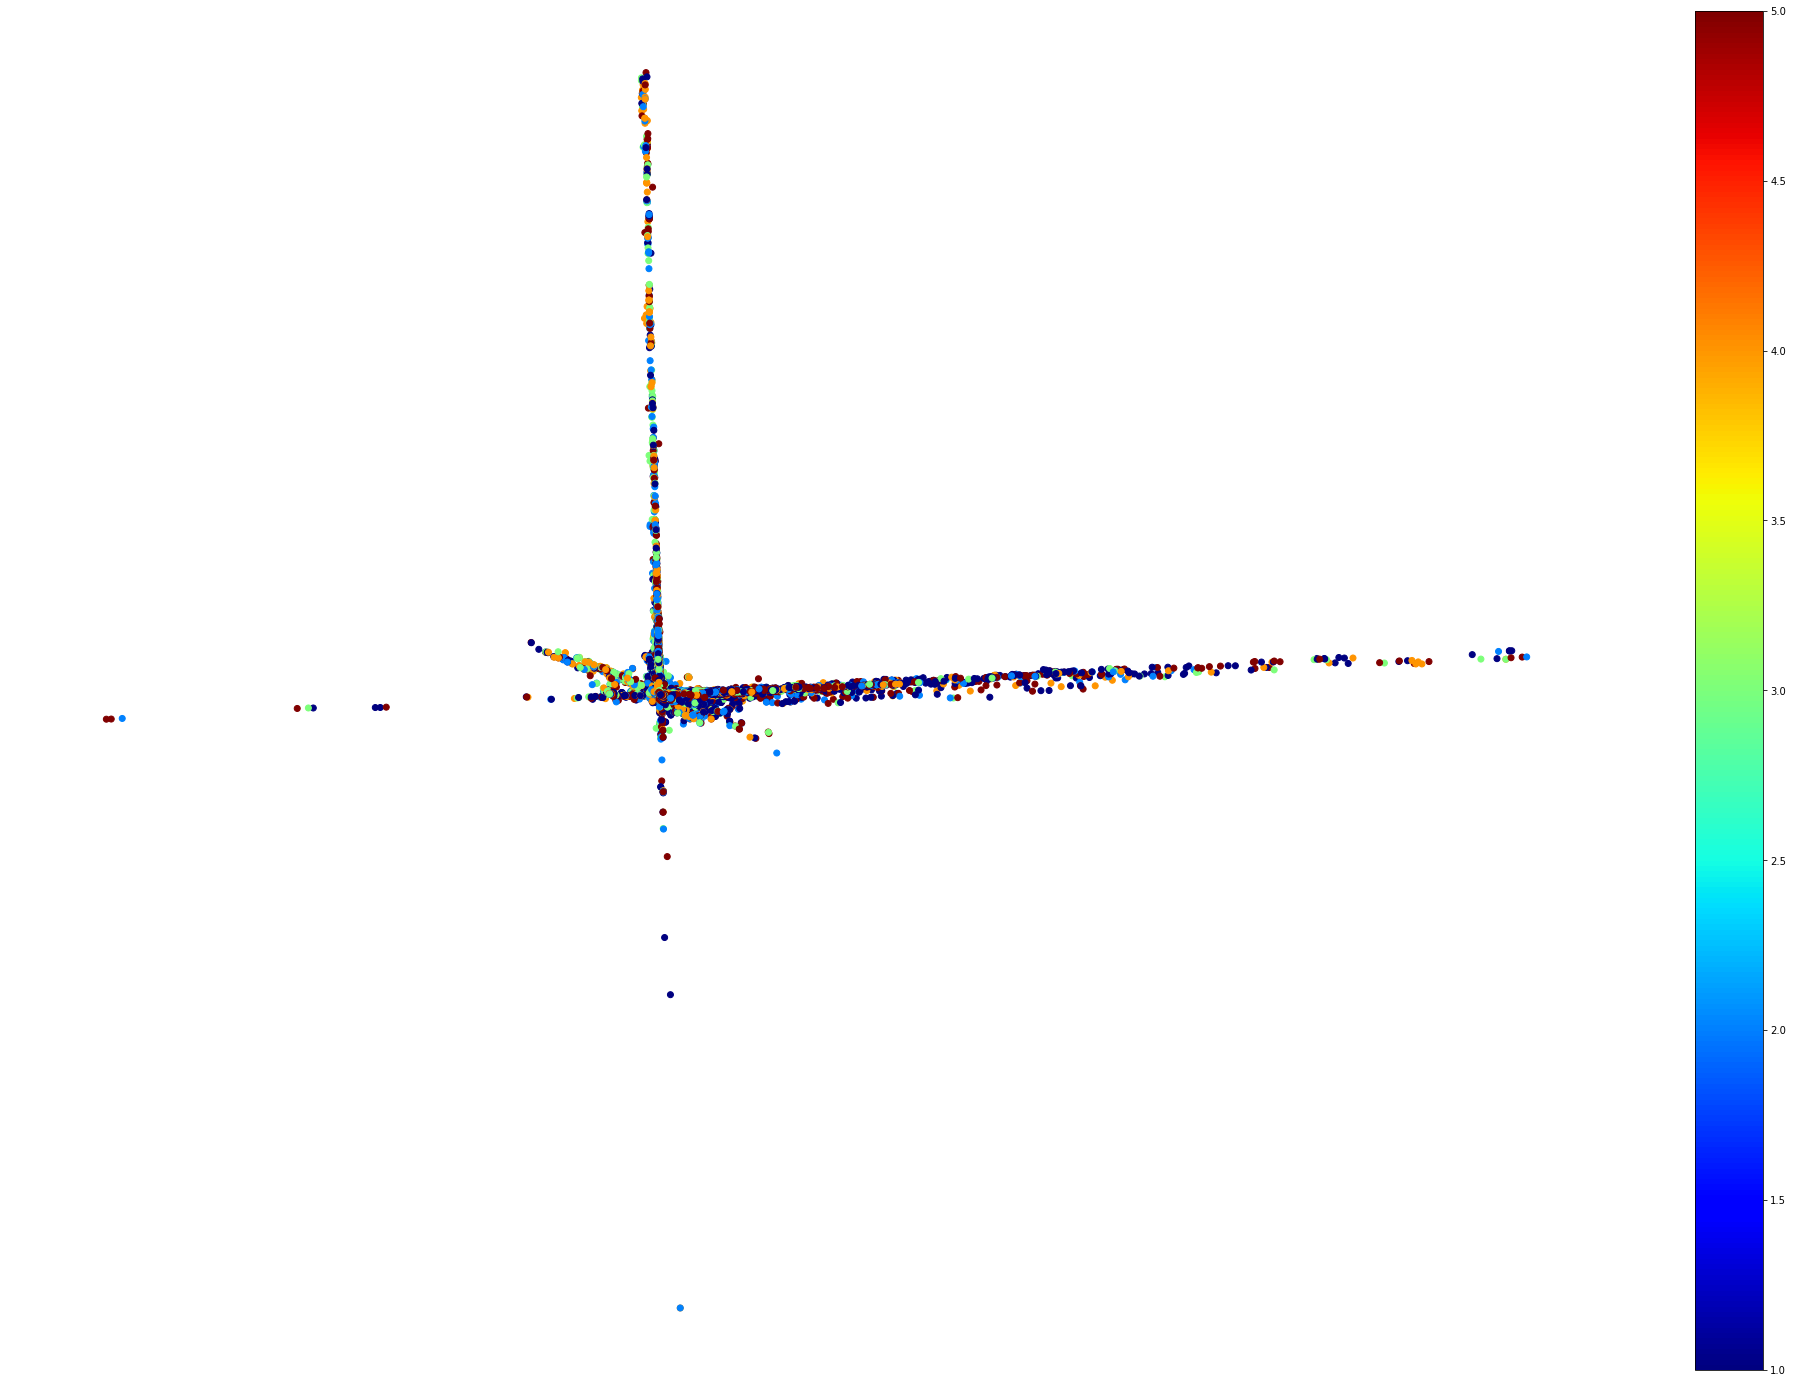

In [22]:
#Only PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
y_label_val = np.concatenate(y_labels.values, axis=None)
plt.figure(figsize=(35,25))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_label_val, cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

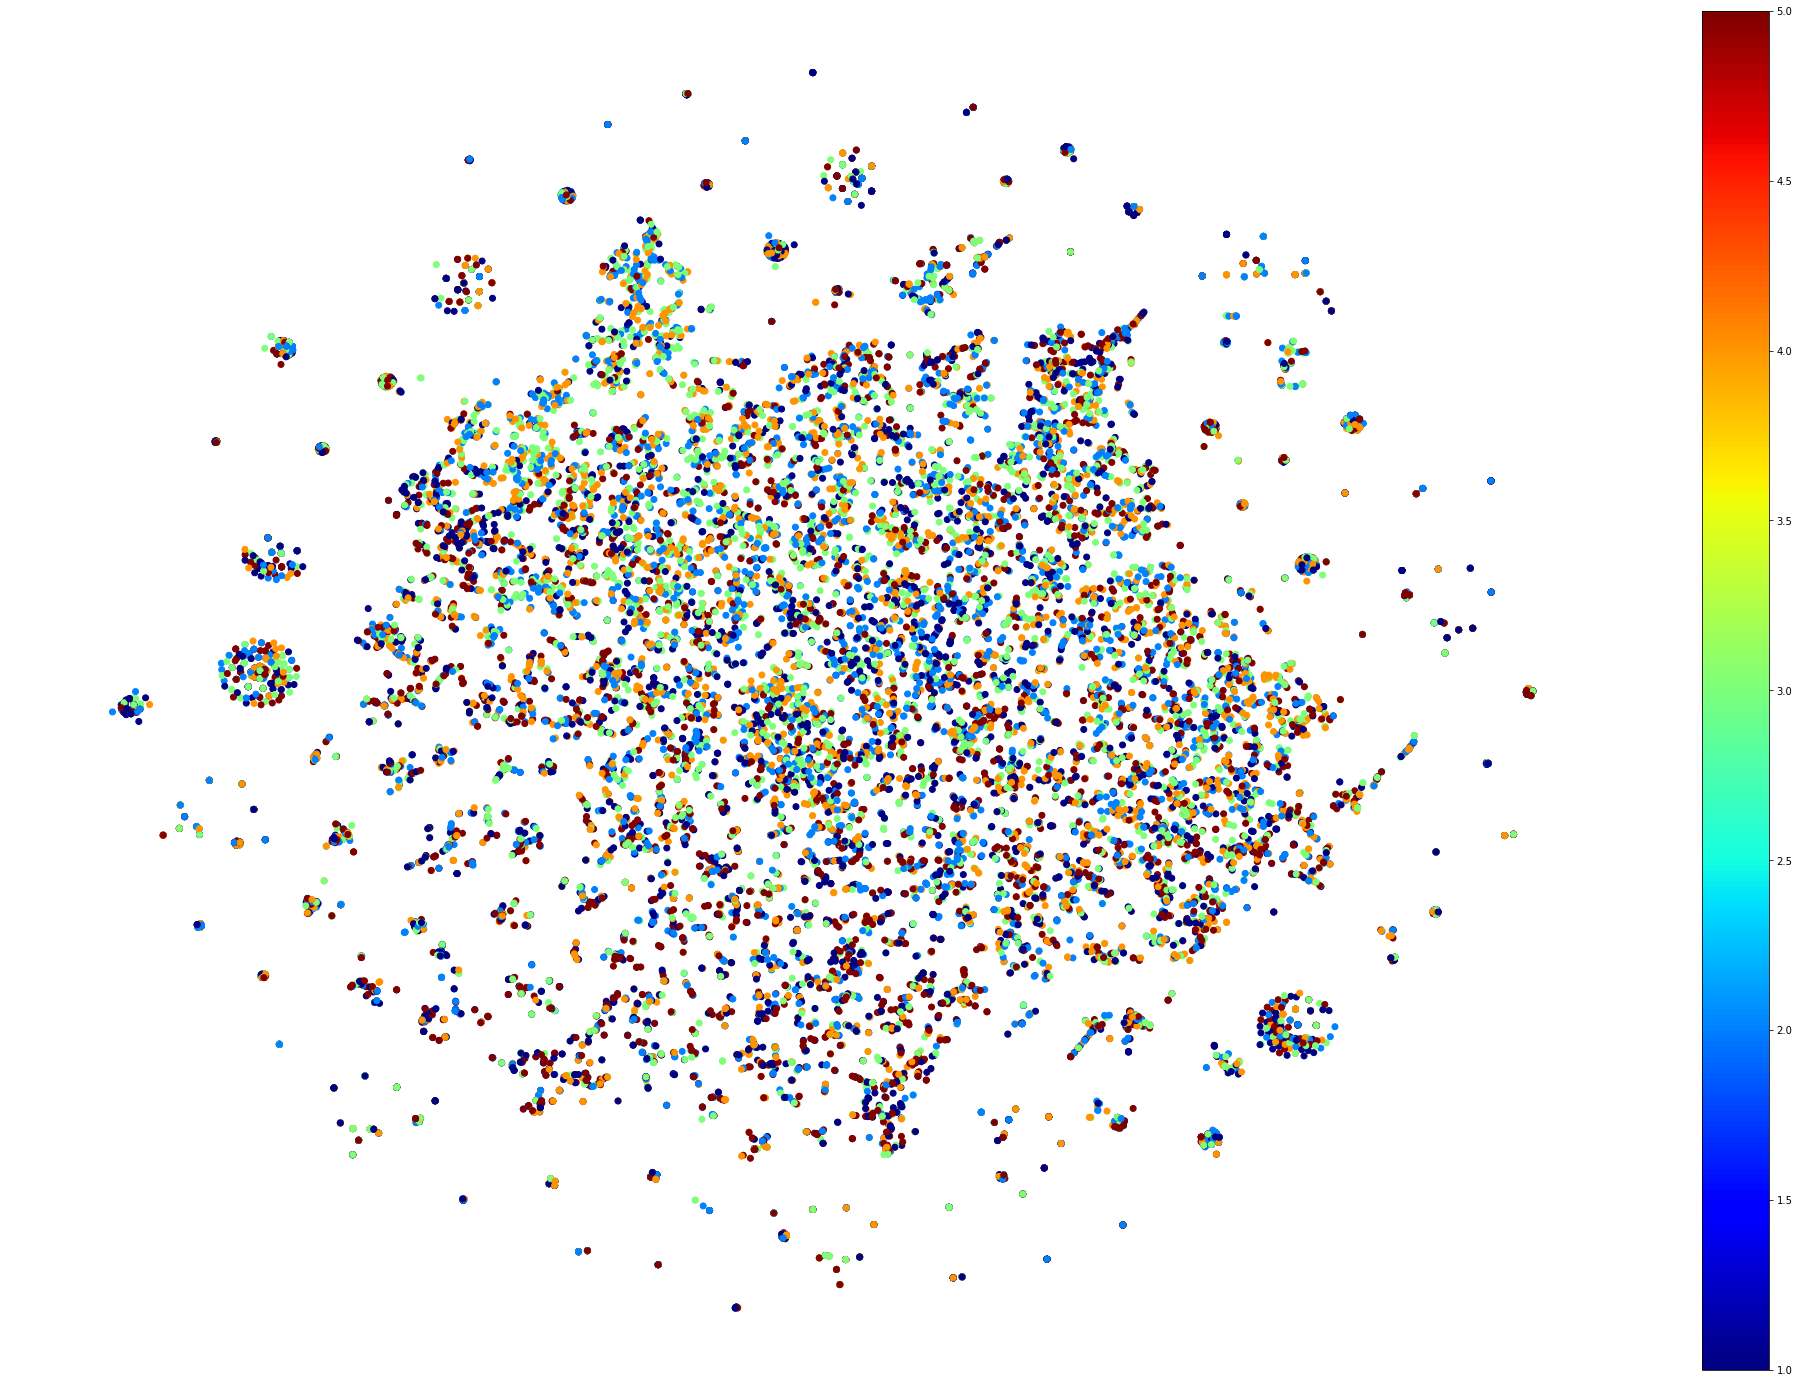

In [71]:
#PCA with TSNE
plt.figure(figsize=(35,25))
plt.scatter(X_pcatsne_reduced[:, 0], X_pcatsne_reduced[:, 1], c=y_label_val[:20000], cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

## 3. Experimental Results

### 3.1 Data Description and Exploratory Data Analysis




Our dataset in this project includes all listed firms in the NYSE, AMEX, and NASDAQ. Our sample begins in January 2009 to April 2019. Our data is monthly updated. We use the Treasury-bill rate as risk-free rate for calculating the excessive returns. The firms characteristics or the factors in other words, include firms' value, growth, solvency, cash flow, profitability, operating capacity, capital structure and momentum. In addition, we include the categorical industry classes corresponding to GICS sectors.    

### 3.2 Out-of-sample Stock-level Prediction Performance



### 3.3 Variable Importance for factors

### 3.4 Machine Learning Portfolios

## 4. Conclusions

## 5. References

Gu, Shihao, Bryan Kelly, and Dacheng Xiu. *Empirical asset pricing via machine learning.* No. w25398. National Bureau of Economic Research, 2018.

